## How much variance does each pc explain for its cluster's genes?

I'm concerned that pcqtls are being driven by the expression of individual genes. 

Stephen suggests the following: 

"We should plot how much variance is explained by each PCqtl and see if there are some where it is imbalanced across genes or pretty similar. You could do a scatterplot of variance explained for gene 1 and gene 2 where gene 1 and 2 are the genes where the most variance is explained (for multi gene clusters beyond 2) "


qtl variance is the suqared effect size, if the data is standardized. I could also look look at the gene variance explianed by the PC itself

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm.auto import tqdm  # for notebooks
import ast


In [103]:
tissue_id = 'Cells_Cultured_fibroblasts' # because only one cell type

prefix = '/home/klawren/oak/pcqtls'

load in data

In [104]:
# load nominal p value dfs

# load in e nominal
def load_e_nominal(path):
    e_nominal_df = pd.read_parquet(path)
    e_nominal_df['cluster_id'] = e_nominal_df['phenotype_id'].str.split('_e_').str[0]
    e_nominal_df['egene_id'] = e_nominal_df['phenotype_id'].str.split('_e_').str[1]
    return e_nominal_df

e_nominal_dfs=[]
for chr_id in tqdm(range(1,23)):
    e_nominal_dfs.append(load_e_nominal(f'{prefix}/output/control_eqtl/{tissue_id}/{tissue_id}.v8.cluster_genes.cis_qtl_pairs.chr{chr_id}.parquet'))

e_nominal_df = pd.concat(e_nominal_dfs)

  0%|          | 0/22 [00:00<?, ?it/s]

In [105]:
def load_pc_nominal(path):
    pc_nominal_df = pd.read_parquet(path)
    pc_nominal_df['cluster_id'] = pc_nominal_df['phenotype_id'].str[:-4]
    return pc_nominal_df

pc1_nominal_dfs=[]
for chr_id in tqdm(range(1,23)):
    pc1_nominal_dfs.append(load_pc_nominal(f'{prefix}/output/pcqtl/{tissue_id}/{tissue_id}.v8.pc_1.cis_qtl_pairs.chr{chr_id}.parquet'))
pc1_nominal_df = pd.concat(pc1_nominal_dfs)


pc2_nominal_dfs=[]
for chr_id in tqdm(range(1,23)):
    pc2_nominal_dfs.append(load_pc_nominal(f'{prefix}/output/pcqtl/{tissue_id}/{tissue_id}.v8.pc_2.cis_qtl_pairs.chr{chr_id}.parquet'))
pc2_nominal_df = pd.concat(pc2_nominal_dfs)

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

In [106]:
overlap_df = pd.read_csv(f'{prefix}/output/overlap/{tissue_id}.v8.overlap.txt', sep='\t')

In [107]:
# label cluster-variant pairs
overlap_df['var_cluster'] = overlap_df['lead_variant_id'] + '_' + overlap_df['cluster_id']
pc1_nominal_df['var_cluster'] = pc1_nominal_df['variant_id'] + '_' + pc1_nominal_df['cluster_id']
pc2_nominal_df['var_cluster'] = pc2_nominal_df['variant_id'] + '_' + pc2_nominal_df['cluster_id']
e_nominal_df['var_cluster'] = e_nominal_df['variant_id'] + '_' + e_nominal_df['cluster_id']

# set e_nominal to be index based on variant-cluster pairs
e_nominal_df_cid = e_nominal_df.set_index('var_cluster')


In [111]:
e_nominal_df

,phenotype_id,variant_id,start_distance,end_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se,cluster_id,egene_id,var_cluster
0,ENSG00000229344.1_ENSG00000240409.1_e_ENSG0000...,chr1_13550_G_A_b38,-619207,-619985,0.017598,17,17,0.138794,0.212430,0.143228,ENSG00000229344.1_ENSG00000240409.1,ENSG00000229344.1,chr1_13550_G_A_b38_ENSG00000229344.1_ENSG00000...
1,ENSG00000229344.1_ENSG00000240409.1_e_ENSG0000...,chr1_14671_G_C_b38,-618086,-618864,0.011387,11,11,0.178194,0.235624,0.174713,ENSG00000229344.1_ENSG00000240409.1,ENSG00000229344.1,chr1_14671_G_C_b38_ENSG00000229344.1_ENSG00000...
2,ENSG00000229344.1_ENSG00000240409.1_e_ENSG0000...,chr1_14677_G_A_b38,-618080,-618858,0.051760,50,50,0.983449,-0.001844,0.088817,ENSG00000229344.1_ENSG00000240409.1,ENSG00000229344.1,chr1_14677_G_A_b38_ENSG00000229344.1_ENSG00000...
3,ENSG00000229344.1_ENSG00000240409.1_e_ENSG0000...,chr1_16841_G_T_b38,-615916,-616694,0.042443,41,41,0.400111,0.080131,0.095134,ENSG00000229344.1_ENSG00000240409.1,ENSG00000229344.1,chr1_16841_G_T_b38_ENSG00000229344.1_ENSG00000...
4,ENSG00000229344.1_ENSG00000240409.1_e_ENSG0000...,chr1_16856_A_G_b38,-615901,-616679,0.014493,14,14,0.029020,0.349043,0.159318,ENSG00000229344.1_ENSG00000240409.1,ENSG00000229344.1,chr1_16856_A_G_b38_ENSG00000229344.1_ENSG00000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
963174,ENSG00000025708.13_ENSG00000177989.13_e_ENSG00...,chr22_50806958_C_CGTCTCTGCGCCGCCGGGGACGTGT_b38,276902,274378,0.009317,9,9,0.508638,-0.065961,0.099708,ENSG00000025708.13_ENSG00000177989.13,ENSG00000177989.13,chr22_50806958_C_CGTCTCTGCGCCGCCGGGGACGTGT_b38...
963175,ENSG00000025708.13_ENSG00000177989.13_e_ENSG00...,chr22_50807078_C_A_b38,277022,274498,0.015119,14,14,0.088443,-0.137355,0.080432,ENSG00000025708.13_ENSG00000177989.13,ENSG00000177989.13,chr22_50807078_C_A_b38_ENSG00000025708.13_ENSG...
963176,ENSG00000025708.13_ENSG00000177989.13_e_ENSG00...,chr22_50807681_C_A_b38,277625,275101,0.012739,12,12,0.023710,0.201808,0.088895,ENSG00000025708.13_ENSG00000177989.13,ENSG00000177989.13,chr22_50807681_C_A_b38_ENSG00000025708.13_ENSG...
963177,ENSG00000025708.13_ENSG00000177989.13_e_ENSG00...,chr22_50807702_A_G_b38,277646,275122,0.031056,30,30,0.874770,-0.008787,0.055717,ENSG00000025708.13_ENSG00000177989.13,ENSG00000177989.13,chr22_50807702_A_G_b38_ENSG00000025708.13_ENSG...


### lead variant only

start with just lead variants from susie (this is not exactly correct but will work for a first pass)

In [108]:
pc1qtl_vars = overlap_df[overlap_df['orig_cs_dataset'] == 'pc_1_qtl']['var_cluster']

In [109]:
# get the eqtl effects for the pcqtl lead variants 
pc1qtl_vars_e_nominal = e_nominal_df_cid.loc[pc1qtl_vars]
pc1qtl_vars_e_nominal.reset_index(inplace=True)
pc1qtl_vars_e_nominal['effect_size'] = pc1qtl_vars_e_nominal['slope']**2

In [110]:
# keep only the largest and 2nd largest effect size for each cluster 
plot_df = pc1qtl_vars_e_nominal.groupby('cluster_id').apply(lambda x: x.nlargest(2, 'effect_size')).reset_index(drop=True)

# Add a rank column with grouped rank numbers
plot_df['rank'] = plot_df.groupby('cluster_id')['effect_size'].rank("dense", ascending=False)

# Pivot the DataFrame
plot_df = plot_df.pivot(index='cluster_id', columns='rank', values='effect_size')

# Rename the columns for clarity
plot_df.columns = ['largest', 'second_largest']

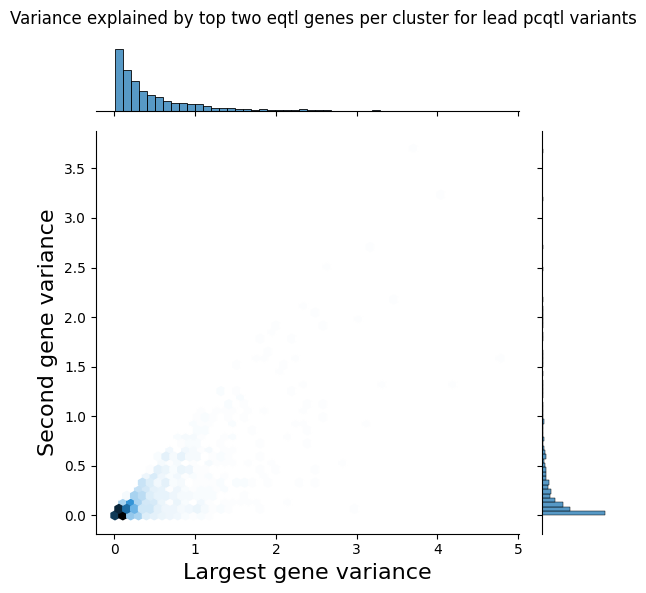

In [10]:
# Create the jointplot
jplot = sns.jointplot(data=plot_df, x='largest', y='second_largest', kind='hex')

# Set labels
jplot.set_axis_labels('Largest gene variance', 'Second gene variance', fontsize=16)

plt.suptitle('Variance explained by top two eqtl genes per cluster for lead pcqtl variants')
jplot.fig.tight_layout()
# Show the plot
plt.show()


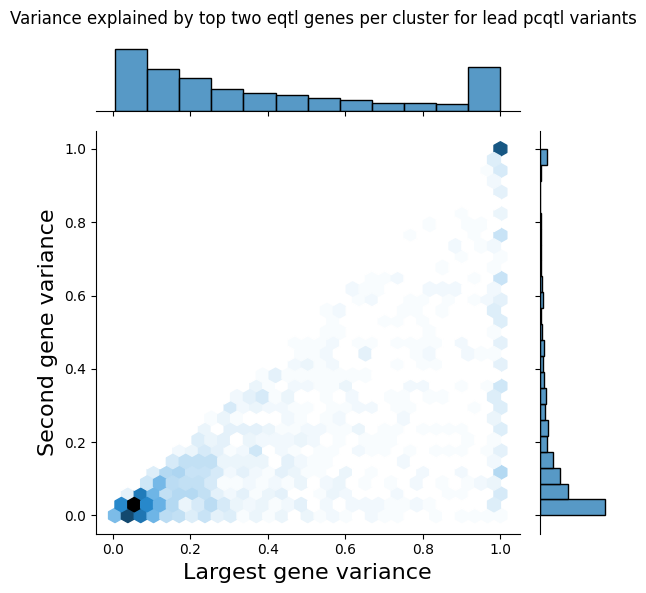

In [11]:
# Create the jointplot
jplot = sns.jointplot(data=plot_df.clip(upper=1), x='largest', y='second_largest', kind='hex', gridsize=30)

# Set labels
jplot.set_axis_labels('Largest gene variance', 'Second gene variance', fontsize=16)

plt.suptitle('Variance explained by top two eqtl genes per cluster for lead pcqtl variants')
jplot.fig.tight_layout()
# Show the plot
plt.show()

### credible set

Rather than just taking the variance of the lead snp, I can expand to take the pip*variance for the whole credible set

In [27]:
# load in the susie df, so I have the pip values for the variants as well as the slopes
pc1_susie_df = pd.read_csv(f'{prefix}/output/pcqtl/{tissue_id}/{tissue_id}.v8.pc_1.susie.txt', sep='\t', index_col=0)
pc1_susie_df['var_cluster'] = pc1_susie_df['variant_id'] + '_' + pc1_susie_df['phenotype_id'].str.split('_pc1').str[0]
pc1_susie_df['cs_id'] =  pc1_susie_df['phenotype_id'].str.split('_pc1').str[0] + '_' + pc1_susie_df['cs_id'].astype(str)

In [82]:
# pull out the variants that are part of a pc1qtl credible set
pc1qtl_cs_e_nominal = e_nominal_df_cid.loc[pc1_susie_df['var_cluster']]
pc1qtl_cs_e_nominal.reset_index(inplace=True)

# add in the pip, then calculate the effects size as a pip weighted slope**2
pc1qtl_cs_e_nominal['pip'] = pc1qtl_cs_e_nominal['var_cluster'].map(pc1_susie_df.set_index('var_cluster')['pip'])
pc1qtl_cs_e_nominal['variance'] = pc1qtl_cs_e_nominal['slope'].apply(np.square)
pc1qtl_cs_e_nominal['variance_weighted'] = pc1qtl_cs_e_nominal['variance'] * pc1qtl_cs_e_nominal['pip']

In [98]:
# group by credible set 
pc1qtl_cs_e_nominal['cs_id'] = pc1qtl_cs_e_nominal['var_cluster'].map(pc1_susie_df.set_index('var_cluster')['cs_id'])
# get the sum of pip weighted variances for the credible set
plot_df = pd.DataFrame(pc1qtl_cs_e_nominal.groupby(['cs_id', 'egene_id'])['variance_weighted'].sum())
# take just the two largest variances
plot_df = plot_df.groupby('cs_id')['variance_weighted'].nlargest(2)

In [99]:
plot_df['rank'] = plot_df.groupby('cs_id')['variance_weighted'].rank("dense", ascending=False)


KeyError: 'Column not found: variance_weighted'

In [ ]:
# Add a rank column with grouped rank numbers
plot_df['rank'] = plot_df.groupby('cs_id')['variance_weighted'].rank("dense", ascending=False)
# Pivot the DataFrame
plot_df = plot_df.pivot(index='cs_id', columns='rank', values='effect_size')
# Rename the columns for clarity
plot_df.columns = ['largest', 'second_largest']

In [ ]:
# Create the jointplot
jplot = sns.jointplot(data=plot_df, x='largest', y='second_largest', kind='hex')

# Set labels
jplot.set_axis_labels('Largest gene variance', 'Second gene variance', fontsize=16)

plt.suptitle('Variance explained by top two eqtl genes per cluster for lead pcqtl variants')
jplot.fig.tight_layout()
# Show the plot
plt.show()


Some of the variances are >100%. This would happen if the slope values are not bounded by [-1,1]. Dan suggests this could be the case if the genotype or expression were not normalized. 

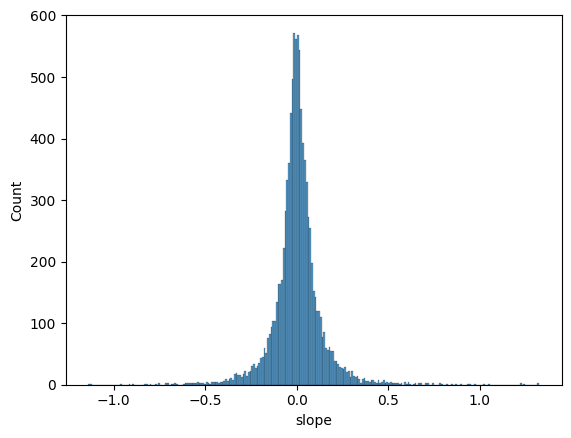

In [58]:
sns.histplot(e_nominal_df.sample(10000), x='slope')
plt.show()

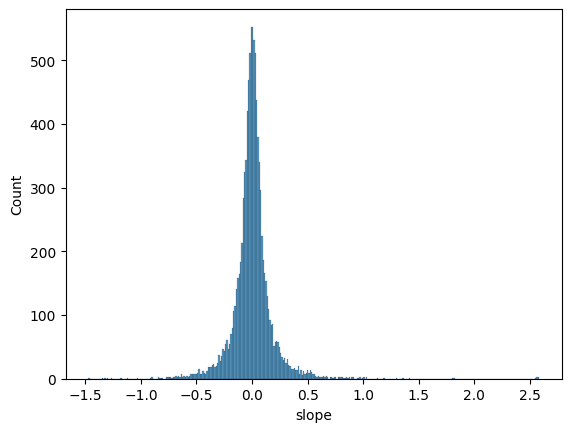

In [59]:
sns.histplot(pc1_nominal_df.sample(10000), x='slope')
plt.show()